In [1]:
from dataloader import get_train_loader
import matplotlib.pyplot as plt
import torch

In [2]:
loader = get_train_loader(
    "./dataset/TrainDataset", 
    batchsize=16, 
    train_size=352,
    num_workers=1)

In [3]:
images, masks = next(iter(loader))

In [5]:
images.shape, masks.shape

(torch.Size([16, 3, 352, 352]), torch.Size([16, 1, 352, 352]))

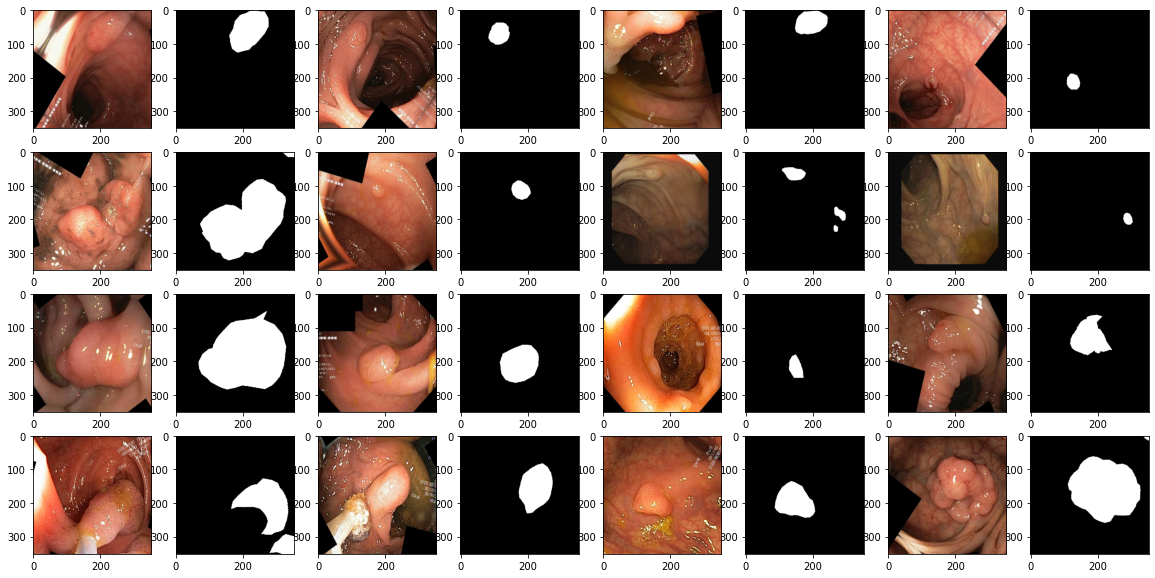

In [6]:
imgs = torch.permute(images, (0, 2, 3, 1))
masks = torch.permute(masks, (0, 2, 3, 1))
plt.figure(figsize=(20, 10))
for i, (img, mask) in enumerate(zip(imgs, masks)):
    plt.subplot(4, 8, 2*i+1)
    plt.imshow(img)
    plt.subplot(4, 8, 2*i+2)
    plt.imshow(mask, cmap='gray')
plt.show()

# Test set

In [7]:
from dataloader import TestDatasets

test_loader = TestDatasets("./dataset/TestDataset/", 352)

In [ ]:
for ds_name in test_loader.DS_NAMES:
    print("ds_name", ds_name)

    n_imgs = test_loader.datasets[ds_name]["n_imgs"]
    print("n_imgs", n_imgs)

    for i in range(n_imgs):
        # Get img, mask
        origin_img, image, gt = test_loader.get_item(ds_name, i)
        # image = image.unsqueeze(0).cuda()

        plt.imshow(gt, cmap="gray")
        plt.show()
